#Random Forest

In [ ]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV

param_grid = { # for tuning
    'n_estimators': [50, 100, 200],
    'max_depth': [None, 10, 20],
    'min_samples_split': [2, 5, 10]
}

grid_search = GridSearchCV(RandomForestClassifier(class_weight="balanced", random_state=123),
                           param_grid,
                           cv=3,
                           scoring="accuracy",
                           n_jobs=-1)

grid_search.fit(X_train, y_train)  # Cross-validation

# Print best parameters
print("Best parameters found:", grid_search.best_params_)

# Get the best model
best_rf_model = grid_search.best_estimator_

Best parameters found: {'max_depth': 10, 'min_samples_split': 2, 'n_estimators': 100}


In [ ]:
# Evaluate on test set
y_pred_rf = best_rf_model.predict(X_test)
print("Final Test Accuracy:", accuracy_score(y_test, y_pred_rf))
print(classification_report(y_test, y_pred_rf))

Final Test Accuracy: 0.9261744966442953
              precision    recall  f1-score   support

           0       0.94      0.98      0.96       413
           1       0.53      0.29      0.38        34

    accuracy                           0.93       447
   macro avg       0.74      0.64      0.67       447
weighted avg       0.91      0.93      0.92       447



The model performs well on non toxic drugs, however, for the toxic molecules, many of them are being classified as non-toxic..

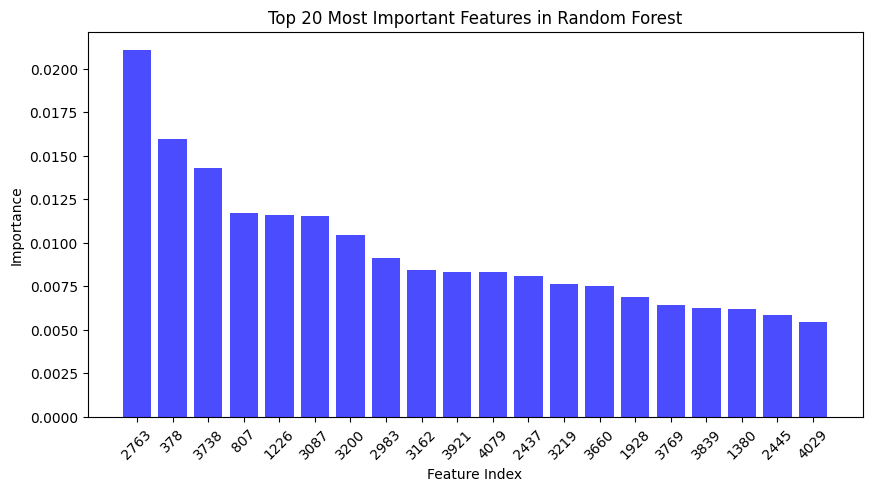

In [ ]:
# Get feature importances
feature_importances = best_rf_model.feature_importances_

top_indices = np.argsort(feature_importances)[::-1][:20]

# Plot the top 20 most important features
plt.figure(figsize=(10, 5))
plt.bar(range(20), sorted(feature_importances, reverse=True)[:20], color='blue', alpha=0.7)
plt.xticks(range(20), top_indices, rotation=45)
plt.xlabel("Feature Index")
plt.ylabel("Importance")
plt.title("Top 20 Most Important Features in Random Forest")
plt.show()

The first few features from the random forest has higher importance scores. There may be 4 features that are promising here.

In [ ]:
top_4_indices = np.argsort(feature_importances)[::-1][:4]
print("Top 4 feature indices (by importance):", top_4_indices)
for idx in top_4_indices:
    print(f"Feature {idx} - Importance: {feature_importances[idx]:.4f}")

Top 4 feature indices (by importance): [2763  378 3738  807]
Feature 2763 - Importance: 0.0211
Feature 378 - Importance: 0.0159
Feature 3738 - Importance: 0.0143
Feature 807 - Importance: 0.0117


I will try to find out the strenght of the strongest feature found here.

In [ ]:
top_feature_idx = np.argsort(feature_importances)[::-1][0]
bit_values = pd.DataFrame(X_train)   .iloc[:, top_feature_idx]
mosaic_data = pd.crosstab(bit_values, y_train)

<Figure size 600x600 with 0 Axes>

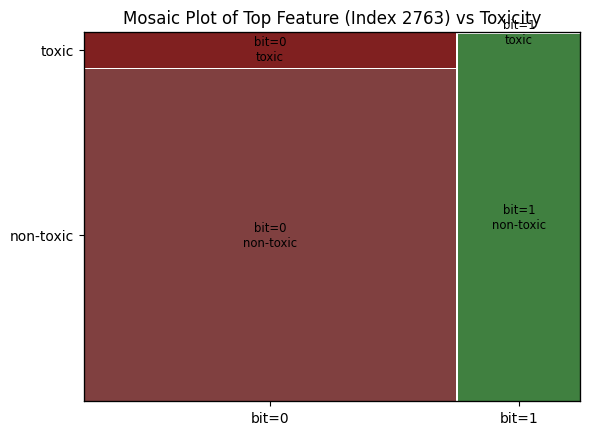

In [ ]:
from statsmodels.graphics.mosaicplot import mosaic
mosaic_data.index = ['bit=0', 'bit=1']
mosaic_data.columns = ['non-toxic', 'toxic']

plt.figure(figsize=(6, 6))
mosaic(mosaic_data.stack())
plt.title(f'Mosaic Plot of Top Feature (Index {top_feature_idx}) vs Toxicity')
plt.show()

The x axis shows the value of feature 2763 in each sample, while the y axis shows the true class labels. Almost all instances with bit = 1 in feature 2763 are classified as non-toxic. Feature 2763's bit value is mostly 0 in the majority of the data, with most being non-toxic. bit = 1 appears like to have a strong association with non-toxicity for this feature.

In [ ]:
X_train_inter = add_interactions(X_train, top_4_indices)
X_test_inter = add_interactions(X_test, top_4_indices)

X_train_aug = np.hstack([X_train, X_train_inter])
X_test_aug = np.hstack([X_test, X_test_inter])


grid_search_aug = GridSearchCV(RandomForestClassifier(class_weight="balanced", random_state=123),
                           param_grid,
                           cv=3,
                           scoring="accuracy",
                           n_jobs=-1)

grid_search_aug.fit(X_train_aug, y_train)  # Cross-validation

# Print best parameters
print("Best parameters found:", grid_search_aug.best_params_)

# Get the best model
best_rf_model_aug = grid_search_aug.best_estimator_

Best parameters found: {'max_depth': 10, 'min_samples_split': 2, 'n_estimators': 200}


In [ ]:
# Evaluate on test set
y_pred_rf_aug = best_rf_model_aug.predict(X_test_aug)
print("Final Test Accuracy:", accuracy_score(y_test, y_pred_rf_aug))
print(classification_report(y_test, y_pred_rf_aug))

Final Test Accuracy: 0.9261744966442953
              precision    recall  f1-score   support

           0       0.94      0.98      0.96       413
           1       0.53      0.29      0.38        34

    accuracy                           0.93       447
   macro avg       0.74      0.64      0.67       447
weighted avg       0.91      0.93      0.92       447



It doesn't seem like there's a lot of changes in the performance.

In [ ]:
n_original = X_train.shape[1]
n_interactions = X_train_inter.shape[1]
interaction_indices = list(range(n_original, n_original + n_interactions))

print("Indices of interaction features:", interaction_indices)

Indices of interaction features: [4096, 4097, 4098, 4099, 4100, 4101]


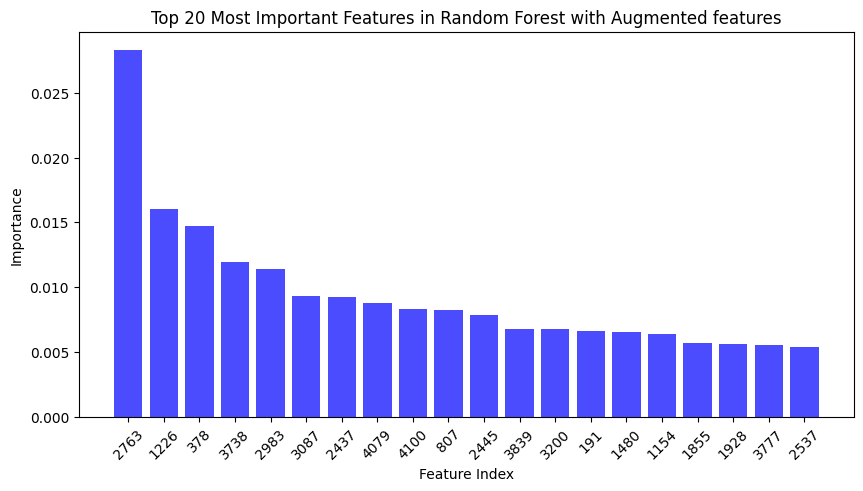

In [ ]:
# Get feature importances
feature_importances_aug = best_rf_model_aug.feature_importances_

top_indices_aug = np.argsort(feature_importances_aug)[::-1][:20]

# Plot the top 20 most important features
plt.figure(figsize=(10, 5))
plt.bar(range(20), sorted(feature_importances_aug, reverse=True)[:20], color='blue', alpha=0.7)
plt.xticks(range(20), top_indices_aug, rotation=45)
plt.xlabel("Feature Index")
plt.ylabel("Importance")
plt.title("Top 20 Most Important Features in Random Forest with Augmented features")
plt.show()

In [ ]:
print(f" top 20 most important features in the original Random Forest {top_indices}")
print(f"Feature importance of 2763 before augmentation: {feature_importances[2763]:.4f} , after augmentation: {feature_importances_aug[2763]:.4f}")


 top 20 most important features in the original Random Forest [2763  378 3738  807 1226 3087 3200 2983 3162 3921 4079 2437 3219 3660
 1928 3769 3839 1380 2445 4029]
Feature importance of 2763 before augmentation: 0.0211 , after augmentation: 0.0283


Feature 1226 became more influetial (from rank 5 to 2) and one of the augmented feature (4100) showed up. The feature importance distribution became flatter. The features that are less important then 4100 can be discarded. It seems like 2763 is the important feature. After adding the augmented features, the importance of this feature increased. I will focus on analyzing what this structure may be below.

In [ ]:
threshold = feature_importances_aug[4100]

# Compare with original top 20
less_important_from_top = [
    idx for idx in top_indices
    if feature_importances_aug[idx] < threshold
]
print("Top features less important than 4100:", less_important_from_top)

remaining_features = [idx for idx in top_indices if idx not in less_important_from_top]
print("Top features more important than 4100:", remaining_features)

Top features less important than 4100: [807, 3200, 3162, 3921, 3219, 3660, 1928, 3769, 3839, 1380, 2445, 4029]
Top features more important than 4100: [2763, 378, 3738, 1226, 3087, 2983, 4079, 2437]


Molecule 2 with Bit Index: 2763


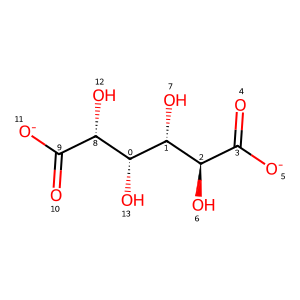

Molecule 5 with Bit Index: 2763


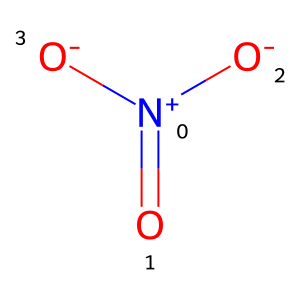

Molecule 7 with Bit Index: 2763


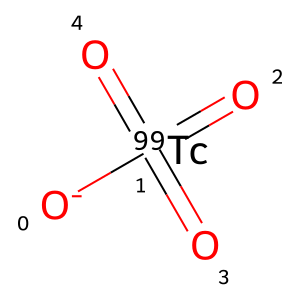

Molecule 8 with Bit Index: 2763


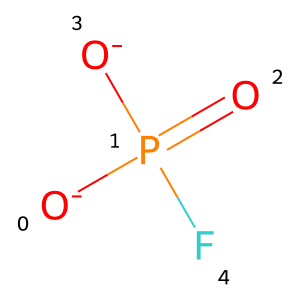

Molecule 9 with Bit Index: 2763


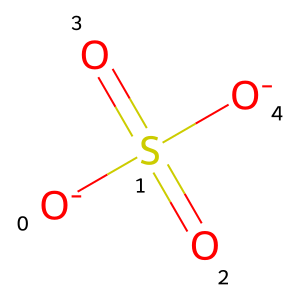

Molecule 10 with Bit Index: 2763


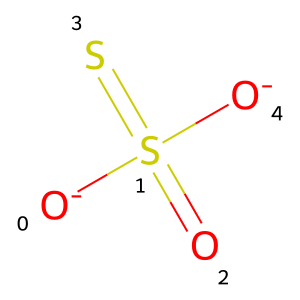

Molecule 17 with Bit Index: 2763


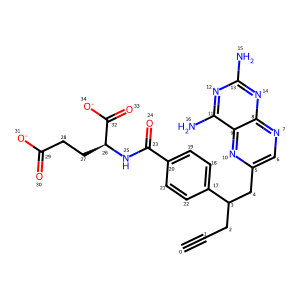

Molecule 20 with Bit Index: 2763


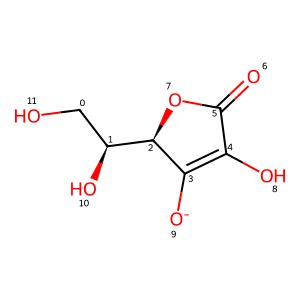

Molecule 21 with Bit Index: 2763


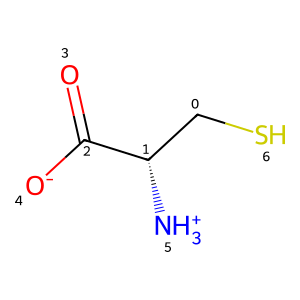

Molecule 29 with Bit Index: 2763


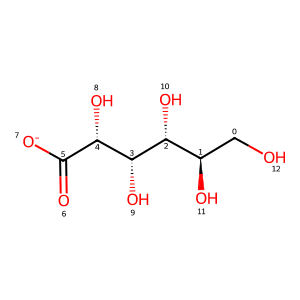

In [ ]:
bit_to_check = 2763
shown = 0
max_to_show = 10

for i in range(len(valid_morgan_data)):
    mol = valid_morgan_data.iloc[i]['mol']
    bit_info = valid_morgan_data.iloc[i]['bitInfo']
    if bit_to_check in bit_info:
        print(f"Molecule {i} with Bit Index: {bit_to_check}")
        svg = show_substructure(mol, bit_to_check, bit_info)
        if svg:
            display(SVG(svg))
            shown += 1
            if shown >= max_to_show:
                break

This substructure may be carboxylate group (COO-).

#XGBoost

In [ ]:
import xgboost as xgb
from sklearn.metrics import accuracy_score, precision_score, recall_score, classification_report
from sklearn.model_selection import train_test_split, GridSearchCV

xgb_clf = xgb.XGBClassifier(
    objective='binary:logistic',
    eval_metric='logloss',
    use_label_encoder=False,
    random_state=123,
    n_jobs=-1
)

xgb_clf.fit(X_train, y_train)
y_pred_xgb = xgb_clf.predict(X_test)

print("XGBoost Performance:")
print("Accuracy:", accuracy_score(y_test, y_pred_xgb))
print("Precision:", precision_score(y_test, y_pred_xgb, zero_division=0))
print("Recall:", recall_score(y_test, y_pred_xgb))
print("\nClassification Report:\n", classification_report(y_test, y_pred_xgb))

XGBoost Performance:
Accuracy: 0.9172259507829977
Precision: 0.42857142857142855
Recall: 0.2647058823529412

Classification Report:
               precision    recall  f1-score   support

           0       0.94      0.97      0.96       413
           1       0.43      0.26      0.33        34

    accuracy                           0.92       447
   macro avg       0.68      0.62      0.64       447
weighted avg       0.90      0.92      0.91       447



The XGBoost performed poorly comparing to the RandomForest..